In [5]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

model_names = [
    "Simple1d",
    "Simple1dEmbedding",
    "Simple2d",
    "Simple2dEmbedding",
    "ResNet50",
    "ResNet50Embedding",
]
target_features = ["endianness", "instructionwidth_type"]

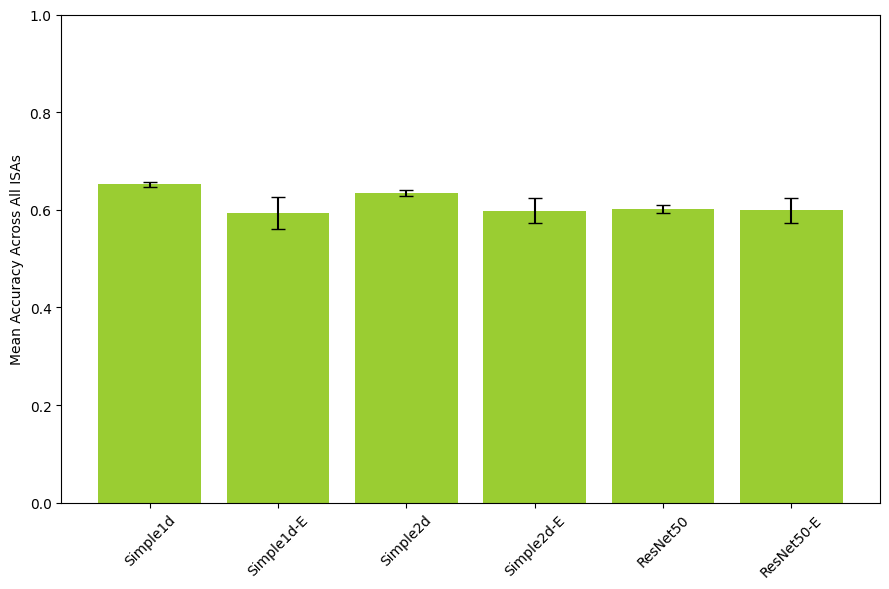

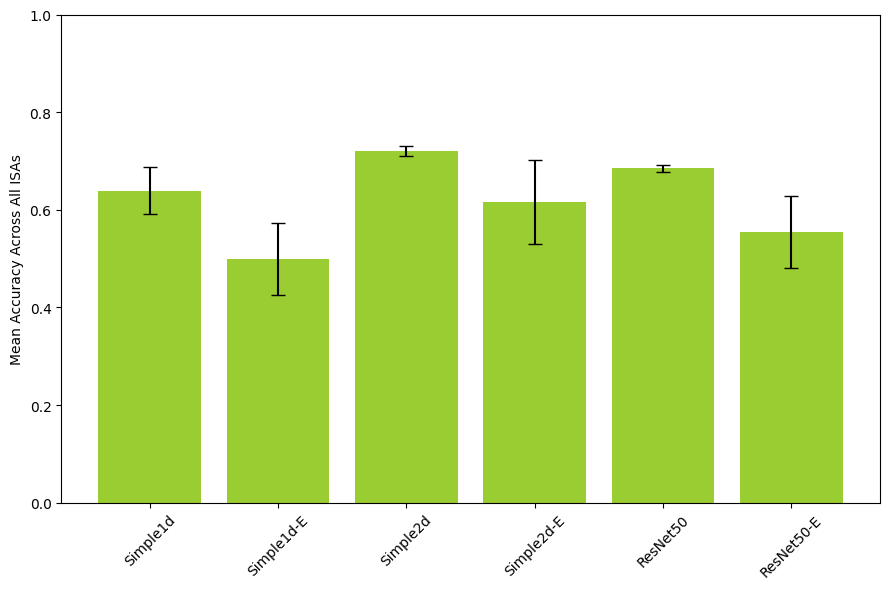

In [6]:
# Specify the directory containing the CSV files
directory = "./input/"  # Change this to your actual path
csv_files = glob.glob(os.path.join(directory, "BuildCross-*.csv"))
df_all = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

for target_feature in target_features:
    model_results = {}

    for model_name in model_names:
        # Filter on model and target feature
        df = df_all[
            (df_all["validator.name"] == "train_test_separate_datasets")
            & (df_all["model.name"] == model_name)
            & (df_all["target_feature"] == target_feature)
        ].reset_index(drop=True)

        model_mean = df["test_accuracy"].mean()
        model_std = df["test_accuracy"].std()

        model_results[model_name] = (model_mean, model_std)

    # Create bar chart aggregated by model
    plt.figure(figsize=(9, 6))
    model_means = []
    model_stds = []

    for model in model_names:
        mean, std = model_results[model]
        model_means.append(mean)
        model_stds.append(std)

    xticks = [model.replace("Embedding", "-E") for model in model_names]

    bars = plt.bar(
        range(len(model_names)),
        model_means,
        yerr=model_stds,
        capsize=5,
        color="yellowgreen",
    )
    plt.xticks(range(len(model_names)), xticks, rotation=45)
    plt.ylabel("Mean Accuracy Across All ISAs")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(
        f"output/buildcross-{target_feature.replace('_', '').lower()}-by-model.png"
    )